# Explaining Medical Insurance Price Prediction Models

In [154]:
#import libraries
import pandas as pd
import scipy
import sklearn
import numpy as np
import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor, cv, DMatrix, plot_importance
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('Medical_insurance.csv')

### Source of dataset: https://www.kaggle.com/datasets/harishkumardatalab/medical-insurance-price-prediction

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Questions:
1. What are the most important factors that affect medical expenses?
2. How well can machine learning models predict medical expenses?
3. How can machine learning models be used to improve the efficiency and profitability of health insurance companies?


## First look at data

In [4]:
df.shape

(2772, 7)

In [5]:
#null values and duplicates
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [6]:
df.duplicated().sum()


1435

In [7]:
df = df.drop_duplicates()

In [8]:
df.shape

(1337, 7)

In [9]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [10]:
df.corr(numeric_only=True) 
# age seems to be the most important feature - can try to infer from the model - SHAP values

,age,bmi,children,charges
age,1.000000,0.109344,0.041536,0.298308
bmi,0.109344,1.000000,0.012755,0.198401
children,0.041536,0.012755,1.000000,0.067389
charges,0.298308,0.198401,0.067389,1.000000


## Data Preprocessing

### Get boolean variables for 'male' and 'smokes'

In [12]:
male = np.zeros(df.shape[0])

In [13]:
male[df['sex']=='male']=1

In [14]:
df['male']= male

In [11]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [12]:
#sex, smoker --> convert to boolean
#region --> dummy variables

#make functions
def smoker_convert(smoker):
    if smoker == 'yes':
        return 1
    else:
        return 0
    

In [13]:
df['smokes'] = df.loc[:,'smoker'].apply(smoker_convert)

In [14]:
df

,age,sex,bmi,children,smoker,region,charges,smokes
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0
1334,18,female,31.920,0,no,northeast,2205.98080,0
1335,18,female,36.850,0,no,southeast,1629.83350,0
1336,21,female,25.800,0,no,southwest,2007.94500,0


## Get dummy variables for region

In [15]:
df['region'] = df['region'].astype('category')
df_new = pd.get_dummies(df, columns=['region'])

In [16]:
df_new

,age,sex,bmi,children,smoker,charges,smokes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,16884.92400,1,False,False,False,True
1,18,male,33.770,1,no,1725.55230,0,False,False,True,False
2,28,male,33.000,3,no,4449.46200,0,False,False,True,False
3,33,male,22.705,0,no,21984.47061,0,False,True,False,False
4,32,male,28.880,0,no,3866.85520,0,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,10600.54830,0,False,True,False,False
1334,18,female,31.920,0,no,2205.98080,0,True,False,False,False
1335,18,female,36.850,0,no,1629.83350,0,False,False,True,False
1336,21,female,25.800,0,no,2007.94500,0,False,False,False,True


In [17]:
df_clean = df_new.drop(['sex', 'smoker'], axis=1)

In [18]:
df_clean

,age,bmi,children,charges,smokes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,False,False,False,True
1,18,33.770,1,1725.55230,0,False,False,True,False
2,28,33.000,3,4449.46200,0,False,False,True,False
3,33,22.705,0,21984.47061,0,False,True,False,False
4,32,28.880,0,3866.85520,0,False,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,0,False,True,False,False
1334,18,31.920,0,2205.98080,0,True,False,False,False
1335,18,36.850,0,1629.83350,0,False,False,True,False
1336,21,25.800,0,2007.94500,0,False,False,False,True


In [93]:
#convert region columns to integers
df_clean.loc[:,['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']] = df_clean.loc[:,['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']].astype(int)

/var/folders/71/v9k425r51tddm6v4ztbmjhy40000gn/T/ipykernel_87588/3458139230.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_clean.loc[:,['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']] = df_clean.loc[:,['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']].astype(int)
/var/folders/71/v9k425r51tddm6v4ztbmjhy40000gn/T/ipykernel_87588/3458139230.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_clean.loc[:,['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']] = df_clean.loc[:,['region_northeast', 'region_northwest', 'region_southeast', 're

In [96]:
df_clean

,age,bmi,children,charges,smokes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,0,1
1,18,33.770,1,1725.55230,0,0,0,1,0
2,28,33.000,3,4449.46200,0,0,0,1,0
3,33,22.705,0,21984.47061,0,0,1,0,0
4,32,28.880,0,3866.85520,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,0,0,1,0,0
1334,18,31.920,0,2205.98080,0,1,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1


In [94]:
#look at correlation
df_clean.corr()

,age,bmi,children,charges,smokes,region_northeast,region_northwest,region_southeast,region_southwest
age,1.000000,0.109344,0.041536,0.298308,-0.025587,0.001868,0.001495,-0.012311,0.009415
bmi,0.109344,1.000000,0.012755,0.198401,0.003746,-0.138178,-0.136138,0.270057,-0.006211
children,0.041536,0.012755,1.000000,0.067389,0.007331,-0.023202,0.026044,-0.023492,0.021538
charges,0.298308,0.198401,0.067389,1.000000,0.787234,0.005945,-0.038695,0.073578,-0.043637
smokes,-0.025587,0.003746,0.007331,0.787234,1.000000,0.002597,-0.036321,0.068282,-0.037168
region_northeast,0.001868,-0.138178,-0.023202,0.005945,0.002597,1.000000,-0.319842,-0.345909,-0.320493
region_northwest,0.001495,-0.136138,0.026044,-0.038695,-0.036321,-0.319842,1.000000,-0.345909,-0.320493
region_southeast,-0.012311,0.270057,-0.023492,0.073578,0.068282,-0.345909,-0.345909,1.000000,-0.346614
region_southwest,0.009415,-0.006211,0.021538,-0.043637,-0.037168,-0.320493,-0.320493,-0.346614,1.000000


In [95]:
#linear regression
#homoskedasticity --> normalize
#features are normally distributed

## EDA:
 data itself(bar, hist)
 compare variables (scatter plot)

In [21]:
import matplotlib.pyplot as plt
from scipy.stats import norm

In [22]:
rng = np.arange(df_clean['age'].min(), df_clean['age'].max(), 0.1)
norm.pdf(df_clean['age'].mean(), df_clean['age'].std())

8.841196836550673e-139

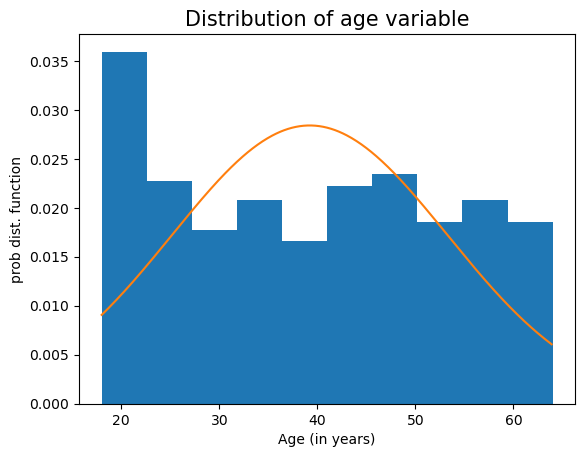

In [23]:
plt.hist(df_clean['age'], density=True) #, bins=20)
rng = np.arange(df_clean['age'].min(), df_clean['age'].max(), 0.1)
plt.plot(rng, norm.pdf(rng, df_clean['age'].mean(), df_clean['age'].std()))
plt.title('Distribution of age variable', size=15)
plt.ylabel('prob dist. function')
plt.xlabel('Age (in years)')
plt.show()

* The age variable is roughly normally distributed

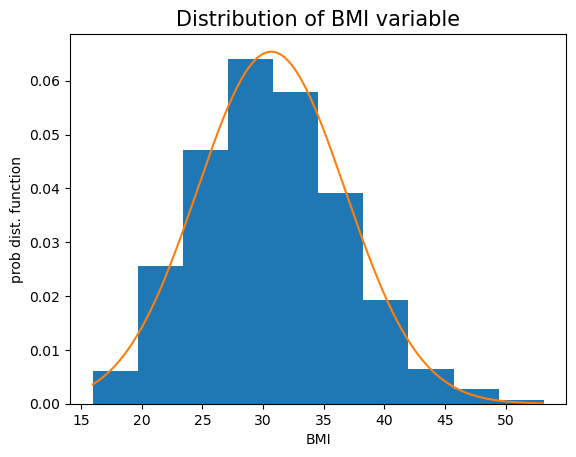

In [24]:
plt.hist(df_clean['bmi'], density=True) #, bins=20)
rng = np.arange(df_clean['bmi'].min(), df_clean['bmi'].max(), 0.1)
plt.plot(rng, norm.pdf(rng, df_clean['bmi'].mean(), df_clean['bmi'].std()))
plt.title('Distribution of BMI variable', size=15)
plt.ylabel('prob dist. function')
plt.xlabel('BMI')
plt.show()

* The age variable is roughly normally distributed

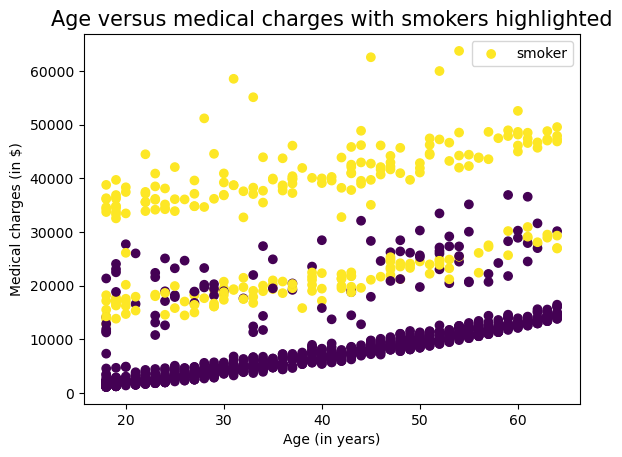

In [25]:
plt.scatter(df_clean['age'], df_clean['charges'], c= df_clean['smokes'], label=['smoker'])
plt.legend(labels = ['smoker'])
plt.title('Age versus medical charges with smokers highlighted', size=15)
plt.ylabel('Medical charges (in $)')
plt.xlabel('Age (in years)')
plt.show()

* On average, within the same age groups, smokers tend to have higher medical charges.

## Standardize and scale columns

In [119]:
from sklearn.preprocessing import StandardScaler

In [120]:
sc =  StandardScaler()

In [156]:
#Create a copy with standardized numerical inputs
df_standardized =df_clean.copy()

In [157]:
pd.DataFrame(sc.fit_transform(df_clean.loc[:,['age','bmi','children','smokes', 'charges']]))

,0,1,2,3,4
0,-1.440418,-0.453160,-0.909234,1.969660,0.297857
1,-1.511647,0.509422,-0.079442,-0.507702,-0.954381
2,-0.799350,0.383155,1.580143,-0.507702,-0.729373
3,-0.443201,-1.305052,-0.909234,-0.507702,0.719104
4,-0.514431,-0.292456,-0.909234,-0.507702,-0.777499
...,...,...,...,...,...
1332,0.767704,0.050269,1.580143,-0.507702,-0.221263
1333,-1.511647,0.206053,-0.909234,-0.507702,-0.914695
1334,-1.511647,1.014490,-0.909234,-0.507702,-0.962287
1335,-1.297958,-0.797524,-0.909234,-0.507702,-0.931054


In [158]:
df_standardized[['age','bmi','children','smokes', 'charges']] = pd.DataFrame(sc.fit_transform(df_clean.loc[:,['age','bmi','children','smokes', 'charges']]))

In [159]:
df_standardized = df_standardized.dropna()
df_standardized

,age,bmi,children,charges,smokes,region_northeast,region_northwest,region_southeast,region_southwest
0,-1.440418,-0.453160,-0.909234,0.297857,1.969660,0,0,0,1
1,-1.511647,0.509422,-0.079442,-0.954381,-0.507702,0,0,1,0
2,-0.799350,0.383155,1.580143,-0.729373,-0.507702,0,0,1,0
3,-0.443201,-1.305052,-0.909234,0.719104,-0.507702,0,1,0,0
4,-0.514431,-0.292456,-0.909234,-0.777499,-0.507702,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1332,0.767704,0.050269,1.580143,-0.221263,-0.507702,0,0,0,1
1333,-1.511647,0.206053,-0.909234,-0.914695,-0.507702,0,1,0,0
1334,-1.511647,1.014490,-0.909234,-0.962287,-0.507702,1,0,0,0
1335,-1.297958,-0.797524,-0.909234,-0.931054,-0.507702,0,0,1,0


In [160]:
# get features and labels
y =  df_clean['charges']
x = df_clean.drop(['charges'], axis=1)

In [164]:
# get standardized features and labels
y_std =  df_standardized['charges']
x_std = df_standardized.drop(['charges'], axis=1)

In [165]:
# train, test split
train_x, test_x, train_y, test_y = train_test_split(x, y)
train_x_std, test_x_std, train_y_std, test_y_std = train_test_split(x_std, y_std)

# ML models for regression
1. Linear Regression
2. Decision Tree Regressors
3. Random Forest Regressors
4. XGBoost Regressors

## Fit Linear Regression model with standardized numerical columns

In [127]:
lr = LinearRegression()

In [166]:
lr.fit(train_x_std, train_y_std)

LinearRegression()

In [171]:
train_pred_std = lr.predict(train_x_std)
test_pred_std = lr.predict(test_x_std)

In [172]:
r2_score(train_pred_std, train_y_std)

0.6231446730998178

In [174]:
r2_score(test_pred_std, test_y_std)

0.6957249552022866

In [175]:
mean_squared_error(train_pred_std, train_y_std)

0.25927241421682673

In [176]:
mean_squared_error(test_pred_std, test_y_std)

0.22579207252936515

### Compute Feature importance using SHAP

In [178]:
explainer = shap.LinearExplainer(lr, train_x_std)
shap_values = explainer.shap_values(test_x_std)

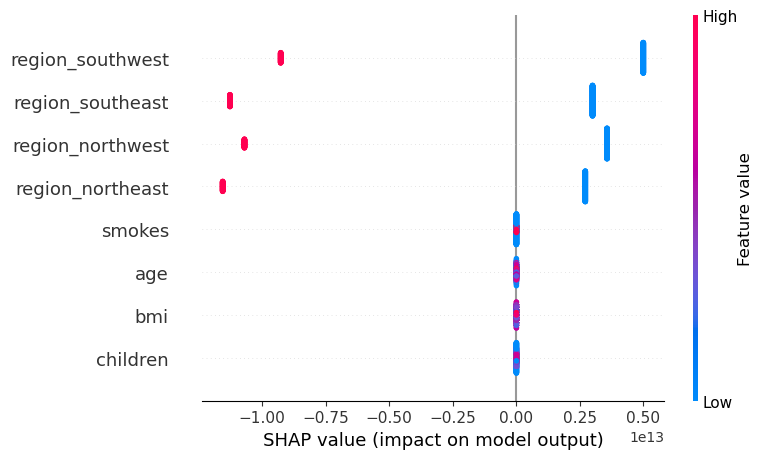

In [182]:
shap.summary_plot(shap_values, test_x_std, feature_names=train_x_std.columns)


* The feature names are in order of importance from top to bottom on the Y-axis
* The SHAP values on the X-axis represent the degree of change in log odds
* Red indicates high valyes and blue indicates low values


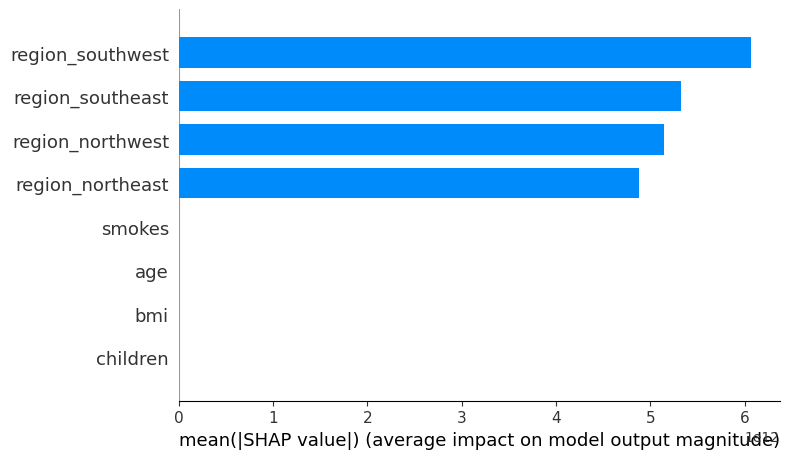

In [183]:
shap.summary_plot(shap_values, test_x_std, plot_type="bar", feature_names = x.columns)

## Inferences:
#### This model relies on region as opposed to other features in encoding predictive power, which is not necessarily useful for this model 

## Retraining linear regression model without standardizing the features

In [184]:
lr.fit(train_x, train_y)

LinearRegression()

In [188]:
train_pred = lr.predict(train_x)
test_pred = lr.predict(test_x)

In [189]:
r2_score(train_pred, train_y)

0.6713549466994604

In [190]:
r2_score(test_pred, test_y)

0.6441318583363469

In [191]:
mean_squared_error(train_pred, train_y)

34899033.874973945

In [192]:
mean_squared_error(test_pred, test_y)

41941030.96616249

### Compute Feature importance using SHAP

In [193]:
explainer = shap.LinearExplainer(lr, train_x)
shap_values = explainer.shap_values(test_x)

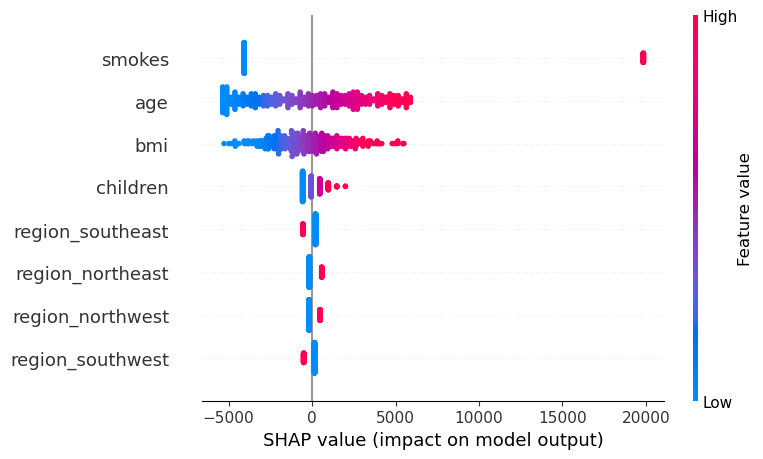

In [195]:
shap.summary_plot(shap_values, test_x, feature_names=train_x.columns)


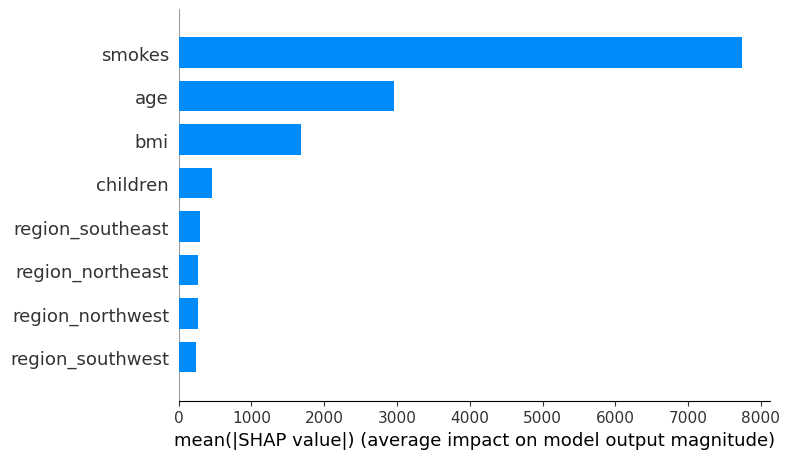

In [196]:
shap.summary_plot(shap_values, test_x, plot_type="bar", feature_names = x.columns)

### This model is picking up predictive power of smokes, age and bmi, which make sense as importance features in determining medical insurance price prediction. This indicates that the Linear Regression model works much better without standardization of numerical columns.

## Fit Random Forest Regressor
Tree based models do not typically require standardization of features, which is why we do not use the standardized dataset

In [217]:
rf = RandomForestRegressor(n_estimators=1000)

In [198]:
rf.fit(train_x, train_y)

RandomForestRegressor(n_estimators=1000)

In [199]:
train_pred_rf = rf.predict(train_x)
test_pred = rf.predict(test_x)

In [200]:
mean_squared_error(train_pred, train_y)

34899033.874973945

In [201]:
mean_squared_error(test_pred, test_y)

22739678.170536254

In [202]:
r2_score(test_pred, test_y)

0.8297678418117567

In [203]:
r2_score(train_pred_rf, train_y)

0.9750544973786405

### Compute feature importance
1. Using scikit-learn feature importance method

In [204]:
rf.feature_importances_

array([0.1334529 , 0.20129611, 0.02178513, 0.62530721, 0.00580029,
       0.00506084, 0.00400036, 0.00329716])

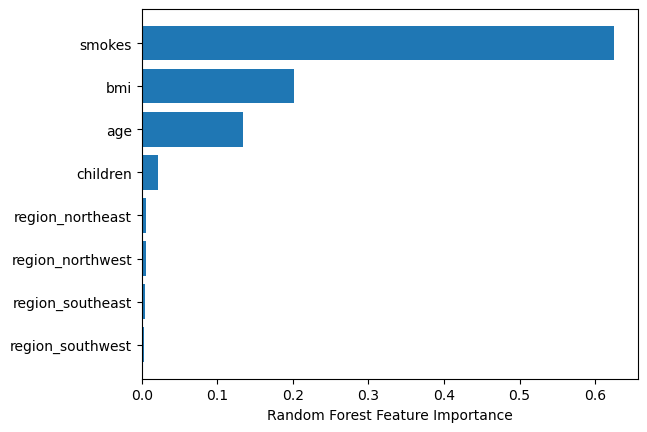

In [205]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

2. Using SHAP

In [206]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test_x)

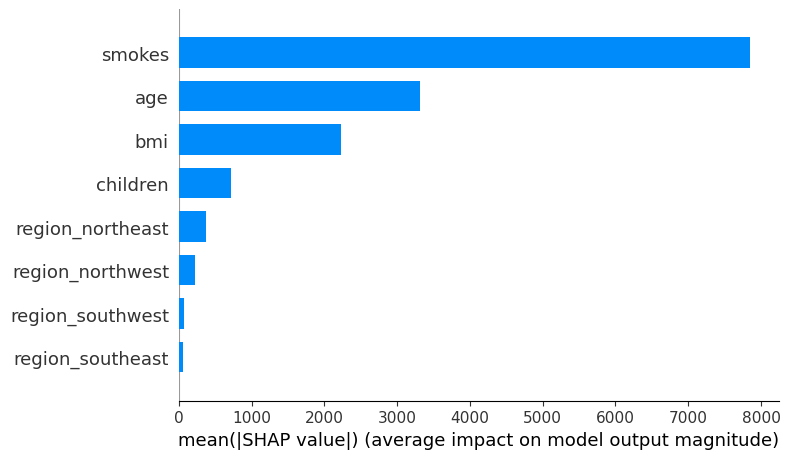

In [207]:
shap.summary_plot(shap_values, test_x, plot_type="bar", feature_names = x.columns)

## Inferences:
#### This model relies primarily on demographic and personal indicators such as smokes, bmi and age to predict price
* There is a slight discrepancy in order of importance of age and bmi as indicators between the feature importance function of sklearn and of the importance indicated by SHAP values

## Fit Decision Tree Classifier

In [208]:
dt = DecisionTreeClassifier()


In [209]:
train_y = train_y.astype(int)

In [210]:
dt.fit(train_x, train_y)

DecisionTreeClassifier()

In [211]:
train_pred_dt = dt.predict(train_x)
test_pred = dt.predict(test_x)

In [212]:
mean_squared_error(test_pred, test_y)

126637264.04472132

In [213]:
r2_score(test_pred, test_y)

0.08300200357137932

In [214]:
r2_score(train_pred_dt, train_y)

0.9988954272793478

In [215]:
mean_squared_error(train_pred_dt, train_y)

155988.0279441118

### Compute feature importance
1. Using scikit-learn feature importance method

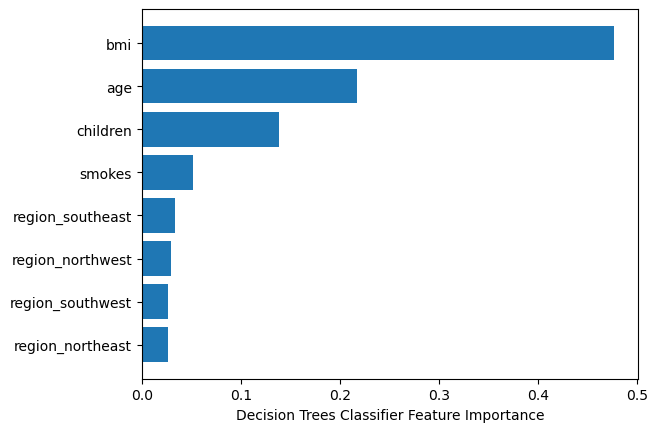

In [216]:
sorted_idx = dt.feature_importances_.argsort()
plt.barh(x.columns[sorted_idx], dt.feature_importances_[sorted_idx])
plt.xlabel("Decision Trees Classifier Feature Importance")
plt.show()

## Inferences:
#### This model is also better than the Linear Regression model as it relies primarily on demographic and personal indicators such as smokes, bmi and age to predict price and less on region

## Fit XGBoost Regressor

In [222]:
xgb = XGBRegressor()

In [223]:
xgb.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [224]:
mean_squared_error(xgb.predict(train_x), train_y)

539231.2465964106

In [225]:
mean_squared_error(xgb.predict(test_x), test_y)

25656474.10723603

In [226]:
r2_score(xgb.predict(test_x), test_y)

0.8180269568770451

In [227]:
r2_score(xgb.predict(train_x), train_y)

0.9960737505355042

### Compute feature importance
1. Using built-in feature importance method

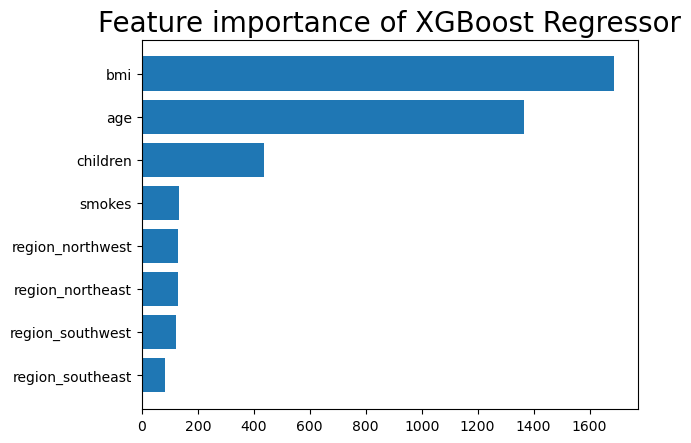

In [228]:
feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(x.columns)
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data2 = data.nlargest(40, columns="score").sort_values(by = "score", ascending=True)
plt.barh(data2.index, data2['score']) ## plot top 40 features
plt.title('Feature importance of XGBoost Regressor', size=20)
plt.show()

2. Using SHAP

In [229]:
explainer = shap.Explainer(xgb)

In [230]:
shap_values = explainer(test_x)

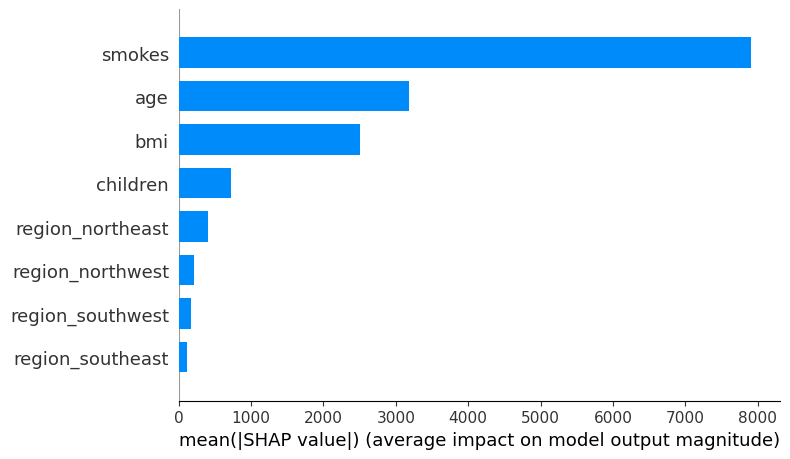

In [231]:
shap.summary_plot(shap_values, test_x, plot_type="bar", feature_names = x.columns)

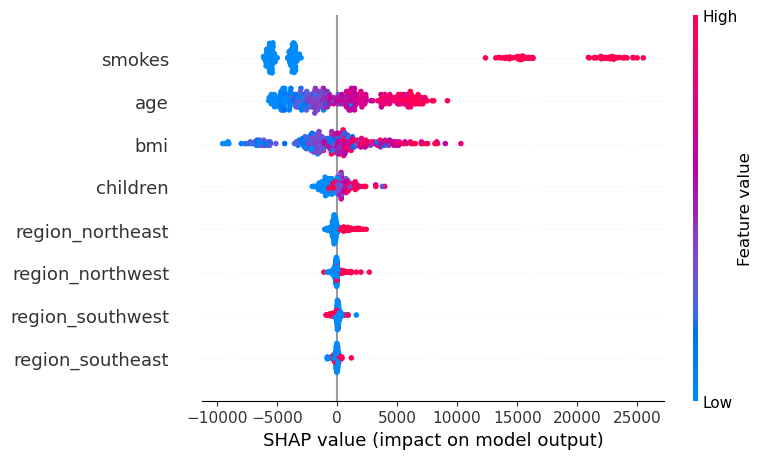

In [232]:
shap.summary_plot(shap_values, test_x, feature_names=x.columns)

### Here, each point represents a prediction

* Higher value of smoking leads to higher medical insurance prices, while lower values lead to lower prices
* Age, bmi and number of children are also roughly directly proportional to medical insurance prices
* People in the northeast seem to have higher insurance price predicted than other regions
